# Imports

In [1]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import talos
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, LSTM
from tensorflow.keras import regularizers

# Load data
load hospitalisations and trends for Belgium and France

In [2]:
# topics considered
list_topics = {
    'Fièvre': '/m/0cjf0',
    'Mal de gorge': '/m/0b76bty',
    'Dyspnée': '/m/01cdt5',
    'Agueusie': '/m/05sfr2',
    'Anosmie': '/m/0m7pl',
    'Coronavirus': '/m/01cpyy',
    'Virus': '/m/0g9pc',
    'Température corporelle humaine': '/g/1213j0cz',
    'Épidémie': '/m/0hn9s',
    'Symptôme': '/m/01b_06',
    'Thermomètre': '/m/07mf1',
    'Grippe espagnole': '/m/01c751',
    'Paracétamol': '/m/0lbt3',
    'Respiration': '/m/02gy9_',
    'Toux': '/m/01b_21'
}

geocodes = {
    'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-C': "Auvergne-Rhône-Alpes",
    'FR-P': "Normandie",
    'FR-D': "Bourgogne-Franche-Comté",
    'FR-E': 'Bretagne',
    'FR-F': 'Centre-Val de Loire',
    'FR-G': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-H': 'Corse',
    'FR-I': "Bourgogne-Franche-Comté",
    'FR-Q': "Normandie",
    'FR-J': 'Ile-de-France',
    'FR-K': 'Languedoc-Roussillon-Midi-Pyrénées',
    'FR-L': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-M': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-N': 'Languedoc-Roussillon-Midi-Pyrénées',
    'FR-O': 'Nord-Pas-de-Calais-Picardie',
    'FR-R': 'Pays de la Loire',
    'FR-S': 'Nord-Pas-de-Calais-Picardie',
    'FR-T': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-U': "Provence-Alpes-Côte d'Azur",
    'FR-V': "Auvergne-Rhône-Alpes",
    'BE': "Belgique"
}

In [42]:
date_begin = "2020-02-01"


def create_dataframe_hospi(hospi_france, hospi_belgium, department_france, geo):
    """
    Creates the dataframe containing the number of daily new hospitalizations
    with respect to the date and the localisation (FR and BE)
    """
    departements = pd.read_csv(department_france)
    hospitalisations = pd.read_csv(hospi_france, sep=";")
    data_fr = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(["regionName", "jour"],
                                                                                                as_index=False).agg(
        {"incid_hosp": "sum"})
    data_fr = data_fr.rename(columns={"jour": "DATE", "incid_hosp": "HOSP", "regionName": "LOC"})

    # Belgian data
    data_be = pd.read_csv(hospi_belgium).groupby(["DATE"]).agg({"NEW_IN": "sum"}).reset_index().rename(
        columns={"NEW_IN": "HOSP"})
    data_be["LOC"] = "Belgique"

    # Full data
    full_data = data_fr.append(data_be).set_index(["LOC", "DATE"])

    # find smallest date for each loc
    smallest = {}
    for loc, date_current in full_data.index:
        if loc not in smallest or smallest[loc] > date_current:
            smallest[loc] = date_current

    base_date = datetime.strptime(date_begin, "%Y-%m-%d").date()

    # Add "fake" data (zeroes before the beginning of the crisis) for each loc
    toadd = []
    for loc, sm in smallest.items():
        end = datetime.strptime(sm, "%Y-%m-%d").date()
        cur = base_date

        while cur != end:
            toadd.append([cur.strftime("%Y-%m-%d"), loc, 0])
            cur += timedelta(days=1)

    full_data = pd.DataFrame(toadd, columns=["DATE", "LOC", "HOSP"]).append(full_data.reset_index()).set_index(
        ["LOC", "DATE"])
    data_dic = {}
    for k, v in geo.items():
        data_dic[k] = full_data.iloc[full_data.index.get_level_values('LOC') == v]
    return data_dic


def create_df_trends(url_trends, geo):
    """
    return dic of {geo: df} for the trends
    """
    renaming = {v: k for k, v in list_topics.items()}  # change topic_mid to topic_title in the dataframe
    result = {}
    for k, v in geo.items():
        all_trends = []
        for term in list_topics.keys():
            path = f"{url_trends}{k}-{term}.csv"
            encoded_path = requests.get(path).content
            df_trends = pd.read_csv(io.StringIO(encoded_path.decode("utf-8"))).rename(columns={"date": "DATE"})
            df_trends['LOC'] = v
            df_trends.rename(columns=renaming, inplace=True)
            df_trends.set_index(['LOC', 'DATE'], inplace=True)
            all_trends.append(df_trends)
        result[k] = pd.concat(all_trends, axis=1)
    return result

In [45]:
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi_belgium = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
url_department_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/france_departements.csv"
url_hospi_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi.csv"
df_trends = create_df_trends(url_trends, geocodes)
df_hospi = create_dataframe_hospi(url_hospi_france, url_hospi_belgium, url_department_france, geocodes)
merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True) for k,v in geocodes.items()}
merged_df

{'FR-A':                                               HOSP  Fièvre  Mal de gorge  \
 LOC                               DATE                                     
 Alsace-Champagne-Ardenne-Lorraine 2020-03-01     0      55            59   
                                   2020-03-02     0      25             0   
                                   2020-03-03     0      34            55   
                                   2020-03-04     0      22            19   
                                   2020-03-05     0      35            28   
 ...                                            ...     ...           ...   
                                   2020-10-16    32      20            22   
                                   2020-10-17    39      11             0   
                                   2020-10-18    25      22            46   
                                   2020-10-19    45      30            21   
                                   2020-10-20   127      29         

# Preprocess data
## Normalization
All data is normalized between [-1,1]
No rolling average is done as we want to be able to use the latest data possible

In [47]:
scaler = MinMaxScaler(feature_range=(-1, 1))
#scaled = scaler.fit_transform(merged_df.values)
#merged_df = pd.DataFrame(scaled, columns=merged_df.columns, index=merged_df.index)
#merged_df
for k in geocodes.keys():
    merged_df[k] = pd.DataFrame(scaler.fit_transform(merged_df[k].values), columns=merged_df[k].columns, index=merged_df[k].index)
merged_df

{'FR-A':                                                   HOSP  Fièvre  Mal de gorge  \
 LOC                               DATE                                         
 Alsace-Champagne-Ardenne-Lorraine 2020-03-01 -1.000000    0.10          0.18   
                                   2020-03-02 -1.000000   -0.50         -1.00   
                                   2020-03-03 -1.000000   -0.32          0.10   
                                   2020-03-04 -1.000000   -0.56         -0.62   
                                   2020-03-05 -1.000000   -0.30         -0.44   
 ...                                                ...     ...           ...   
                                   2020-10-16 -0.908178   -0.60         -0.56   
                                   2020-10-17 -0.888092   -0.78         -1.00   
                                   2020-10-18 -0.928264   -0.56         -0.08   
                                   2020-10-19 -0.870875   -0.40         -0.58   
                    

## Days used for the forecast
Each forecast is done for `n_forecast` days and uses `n_samples` days before to construct the prediction

In [48]:
n_forecast = 3  # Number of days we want to predict
n_samples = 14  # Number of days used to make the prediction

In [52]:
def timeseries_add_lag(data, lag, dropna=True):
    """
    add lagged values to dataframe
    """
    df = pd.DataFrame(data)
    init_columns = df.columns
    columns = [df.shift(i) for i in range(lag-1, 0, -1)]
    renaming = {}  # rename the columns
    delay = lag-1
    for i in range(lag-1):
        for k in init_columns:
            renaming[k] = f'{k}(t-{delay})'
        columns[i].rename(columns=renaming ,inplace=True)
        delay -= 1
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df.dropna() if dropna else df

n_features = merged_df['BE'].shape[1]
lagged_df = {}
for k in geocodes.keys():
    lagged_df[k] = timeseries_add_lag(merged_df[k], n_samples)
lagged_df['BE']

HOSP(t-13)  Fièvre(t-13)  Mal de gorge(t-13)  \
LOC      DATE                                                       
Belgique 2020-03-14   -1.000000     -0.419355           -0.541667   
         2020-03-15   -1.000000     -0.440860           -0.520833   
         2020-03-16   -1.000000     -0.462366           -0.541667   
         2020-03-17   -1.000000     -0.548387           -0.416667   
         2020-03-18   -1.000000     -0.462366           -0.687500   
...                         ...           ...                 ...   
         2020-10-16   -0.767886     -0.677419           -0.791667   
         2020-10-17   -0.726550     -0.763441           -0.270833   
         2020-10-18   -0.723370     -0.591398           -0.437500   
         2020-10-19   -0.669316     -0.655914           -0.687500   
         2020-10-20   -0.580286     -0.741935           -0.812500   

                     Dyspnée(t-13)  Agueusie(t-13)  Anosmie(t-13)  \
LOC      DATE                                                       
Belgique 2020-03-14           0.72           -1.00          -1.00   
         2020-03-15           0.14           -1.00          -1.00   
         2020-03-16          -0.08           -1.00          -1.00   
         2020-03-17           0.04           -1.00          -0.84   
         2020-03-18          -0.34           -0.64          -0.84   
...                            ...             ...            ...   
         2020-10-16          -0.70           -1.00          -0.44   
         2020-10-17          -0.72           -1.00          -1.00   
         2020-10-18          -0.74           -0.64          -1.00   
         2020-10-19          -0.48           -0.28          -1.00   
         2020-10-20          -0.60            0.08          -0.76   

                     Coronavirus(t-13)  Virus(t-13)  \
LOC      DATE                                         
Belgique 2020-03-14          -0.548387    -0.142857   
         2020-03-15          -0.505376     0.020408   
         2020-03-16          -0.548387    -0.102041   
         2020-03-17          -0.591398    -0.224490   
         2020-03-18          -0.505376    -0.081633   
...                                ...          ...   
         2020-10-16          -0.956989    -0.938776   
         2020-10-17          -0.956989    -0.979592   
         2020-10-18          -0.913978    -0.959184   
         2020-10-19          -0.870968    -0.959184   
         2020-10-20          -0.849462    -0.938776   

                     Température corporelle humaine(t-13)  Épidémie(t-13)  \
LOC      DATE                                                               
Belgique 2020-03-14                                 -0.78           -0.48   
         2020-03-15                                 -0.82           -0.58   
         2020-03-16                                 -0.60           -0.48   
         2020-03-17                                 -0.80           -0.60   
         2020-03-18                                 -0.42           -0.64   
...                                                   ...             ...   
         2020-10-16                                 -0.68           -0.86   
         2020-10-17                                 -0.78           -0.86   
         2020-10-18                                 -0.44           -0.90   
         2020-10-19                                 -0.80           -0.88   
         2020-10-20                                 -0.80           -0.88   

                     ...  Coronavirus     Virus  \
LOC      DATE        ...                          
Belgique 2020-03-14  ...     0.677419  0.653061   
         2020-03-15  ...     0.827957  0.816327   
         2020-03-16  ...     0.634409  0.632653   
         2020-03-17  ...     0.548387  0.204082   
         2020-03-18  ...     0.354839  0.183673   
...                  ...          ...       ...   
         2020-10-16  ...    -0.612903 -0.877551   
         2020-10-17  ...    -0.806452 -0.938776 

In [55]:
# shape format for LSTM: [nb_samples, timesteps, input_dim]
dataset = {}
for k in geocodes.keys():
    dataset[k] = lagged_df[k].values.reshape(lagged_df[k].shape[0], n_samples, n_features)
dataset['BE'].shape

(221, 14, 16)

We want the targets to be always differents. For instance, if we use 2 days of forecast based on 3 days of data and the days are indexed as integers we want to have:
1. `x: [1,2,3]`, `y: [4,5]`
2. `x: [3,4,5]`, `y: [6,7]`
2. `x: [5,6,7]`, `y: [8,9]`

and so on

In [93]:
# we take all possible dates for y. If not all dates can be taken, the first dates are dropped
first_set = (len(dataset) - 1) % n_forecast
x_set = {}
y_set = {}
for k in geocodes.keys():
    y_set[k] = np.array([ [dataset[k][i+j+1,n_samples-1,0] for j in range(n_forecast)] for i in range(first_set, len(dataset[k])-n_forecast,n_forecast)])
    x_set[k] = np.array([ dataset[k][i] for i in range(first_set, len(dataset[k])-n_forecast,n_forecast)])
    y_set[k] = y_set[k].reshape(len(x_set[k]), n_forecast, 1)
print(f"len(dataset['BE'])= {len(dataset['BE'])}\t first_set = {first_set}\n{len(y_set['BE'])} sets can be used for training or testing for each region")

len(dataset['BE'])= 221	 first_set = 1
73 sets can be used for training or testing for each region


In [94]:
dates = lagged_df['BE'].index.get_level_values(1)
x_dates = [ dates[i] for i in range(first_set, len(dataset['BE'])-n_forecast,n_forecast)]
y_dates = [ [dates[i+j+1] for j in range(n_forecast)] for i in range(first_set, len(dataset['BE'])-n_forecast,n_forecast)]
print(f'y_dates=\n', y_dates)
print(f'x_dates=\n', x_dates)

y_dates=
 [['2020-03-16', '2020-03-17', '2020-03-18'], ['2020-03-19', '2020-03-20', '2020-03-21'], ['2020-03-22', '2020-03-23', '2020-03-24'], ['2020-03-25', '2020-03-26', '2020-03-27'], ['2020-03-28', '2020-03-29', '2020-03-30'], ['2020-03-31', '2020-04-01', '2020-04-02'], ['2020-04-03', '2020-04-04', '2020-04-05'], ['2020-04-06', '2020-04-07', '2020-04-08'], ['2020-04-09', '2020-04-10', '2020-04-11'], ['2020-04-12', '2020-04-13', '2020-04-14'], ['2020-04-15', '2020-04-16', '2020-04-17'], ['2020-04-18', '2020-04-19', '2020-04-20'], ['2020-04-21', '2020-04-22', '2020-04-23'], ['2020-04-24', '2020-04-25', '2020-04-26'], ['2020-04-27', '2020-04-28', '2020-04-29'], ['2020-04-30', '2020-05-01', '2020-05-02'], ['2020-05-03', '2020-05-04', '2020-05-05'], ['2020-05-06', '2020-05-07', '2020-05-08'], ['2020-05-09', '2020-05-10', '2020-05-11'], ['2020-05-12', '2020-05-13', '2020-05-14'], ['2020-05-15', '2020-05-16', '2020-05-17'], ['2020-05-18', '2020-05-19', '2020-05-20'], ['2020-05-21', '2020-

## Split into train - test set

In [95]:
train_ratio = 0.50
valid_ratio = 0.25
test_ratio = 1.0 - train_ratio - valid_ratio - 1/len(geocodes)

# rescale for sum to be equal to 1
previous_sum = train_ratio + valid_ratio + test_ratio
train_ratio /= previous_sum
valid_ratio /= previous_sum
test_ratio /= previous_sum

all_locs = list(geocodes.keys())
force_test = 'BE'  # forced to be placed in test set
all_locs.remove(force_test)
np.random.shuffle(all_locs)
length = len(all_locs)
train_len = math.ceil(length * train_ratio)
valid_len = math.ceil(length * valid_ratio)

train_datapoints = {loc: (x_set[loc], y_set[loc]) for loc in all_locs[0:train_len]}
valid_datapoints = {loc: (x_set[loc], y_set[loc]) for loc in all_locs[train_len:train_len + valid_len]}
test_datapoints = {loc: (x_set[loc], y_set[loc]) for loc in all_locs[train_len + valid_len:]}
test_datapoints[force_test] = (x_set[force_test], y_set[force_test])


In [96]:
def train_generator():
    while True:
        for loc in train_datapoints:
            yield train_datapoints[loc]

def validation_generator():
    while True:
        for loc in valid_datapoints:
            yield valid_datapoints[loc]

# Toy model

In [97]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features)))
model.add(Dense(n_forecast))

#history = model.fit(x_train, y_train, epochs=400, verbose=1, shuffle=False)
model.compile(loss="mse", optimizer='adam')
history = model.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=400, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/400
12/12 [==============================] - 0s 32ms/step - loss: 0.2196 - val_loss: 0.1148
Epoch 2/400
12/12 [==============================] - 0s 8ms/step - loss: 0.1236 - val_loss: 0.1107
Epoch 3/400
12/12 [==============================] - 0s 16ms/step - loss: 0.1021 - val_loss: 0.0949
Epoch 4/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0894 - val_loss: 0.0821
Epoch 5/400
12/12 [==============================] - 0s 8ms/step - loss: 0.0748 - val_loss: 0.0694
Epoch 6/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0615 - val_loss: 0.0585
Epoch 7/400
12/12 [==============================] - 0s 15ms/step - loss: 0.0507 - val_loss: 0.0515
Epoch 8/400
12/12 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0484
Epoch 9/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0417 - val_loss: 0.0453
Epoch 10/400
12/12 [==============================] - 0s 12ms/step - loss: 0.0392 - val_loss: 0.0430
E

12/12 [==============================] - 0s 8ms/step - loss: 0.0183 - val_loss: 0.0342
Epoch 83/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0182 - val_loss: 0.0343
Epoch 84/400
12/12 [==============================] - 0s 8ms/step - loss: 0.0181 - val_loss: 0.0344
Epoch 85/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0180 - val_loss: 0.0345
Epoch 86/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0180 - val_loss: 0.0346
Epoch 87/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.0347
Epoch 88/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0179 - val_loss: 0.0348
Epoch 89/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0178 - val_loss: 0.0350
Epoch 90/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0178 - val_loss: 0.0351
Epoch 91/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0178 - val_loss: 0.0353
Epoch 92/400


12/12 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0367
Epoch 164/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0368
Epoch 165/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0369
Epoch 166/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0370
Epoch 167/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0371
Epoch 168/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0372
Epoch 169/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0372
Epoch 170/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0373
Epoch 171/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0374
Epoch 172/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0375
Epoc

12/12 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0434
Epoch 245/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0418
Epoch 246/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0443
Epoch 247/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0424
Epoch 248/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0079 - val_loss: 0.0426
Epoch 249/400
12/12 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0442
Epoch 250/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0439
Epoch 251/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0422
Epoch 252/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0444
Epoch 253/400
12/12 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0436
Epoc

12/12 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0460
Epoch 326/400
12/12 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.0458
Epoch 327/400
12/12 [==============================] - 0s 8ms/step - loss: 0.0062 - val_loss: 0.0452
Epoch 328/400
12/12 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0462
Epoch 329/400
12/12 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0463
Epoch 330/400
12/12 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0458
Epoch 331/400
12/12 [==============================] - 0s 9ms/step - loss: 0.0061 - val_loss: 0.0465
Epoch 332/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0060 - val_loss: 0.0465
Epoch 333/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0458
Epoch 334/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0472
E

TRAINING FR-G


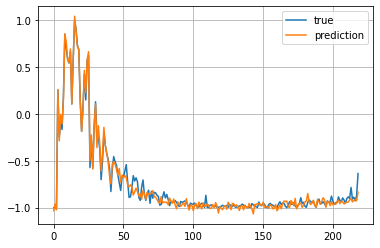

TRAINING FR-B


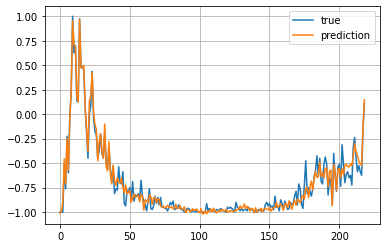

TRAINING FR-N


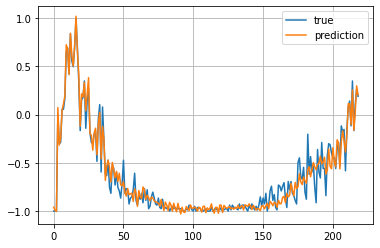

TRAINING FR-K


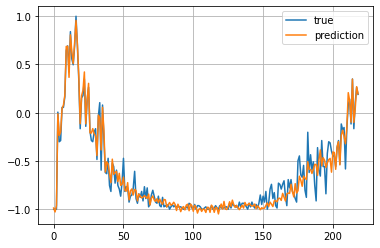

TRAINING FR-J


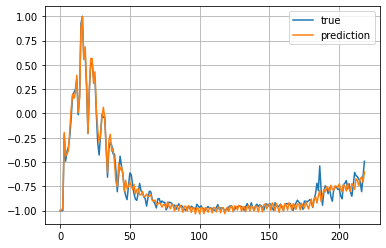

TRAINING FR-M


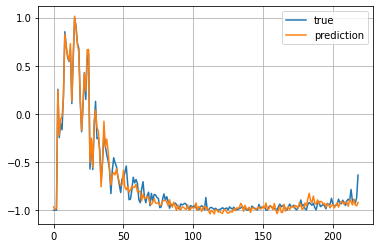

TRAINING FR-I


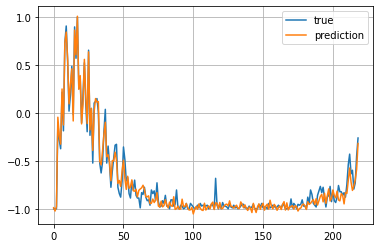

TRAINING FR-R


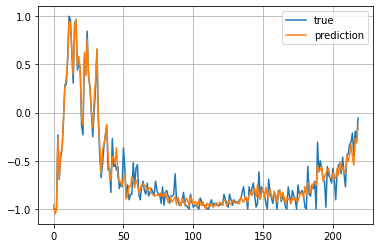

TRAINING FR-Q


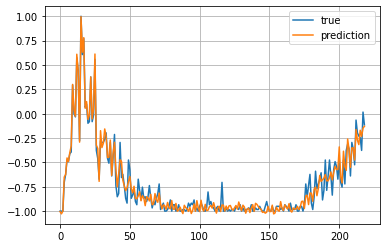

TRAINING FR-S


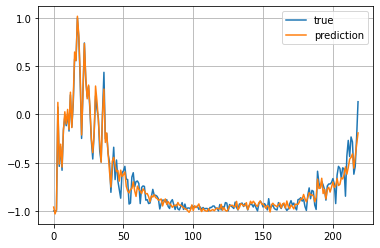

TRAINING FR-A


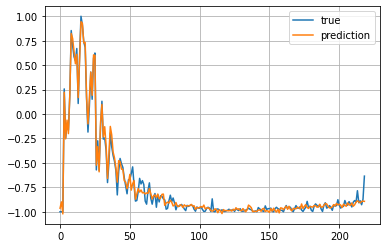

TRAINING FR-T


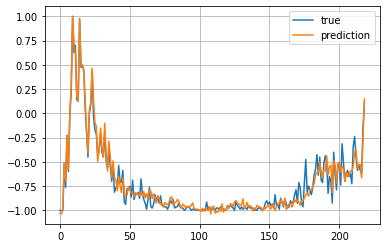

VALIDATION FR-P


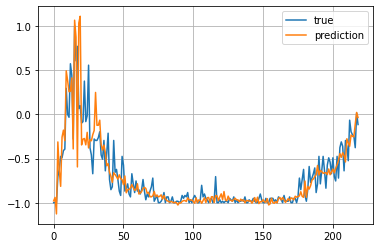

VALIDATION FR-H


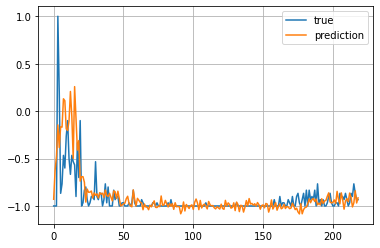

VALIDATION FR-E


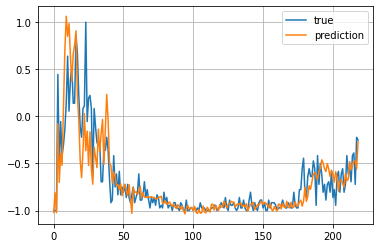

VALIDATION FR-U


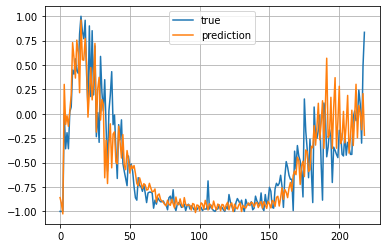

VALIDATION FR-F


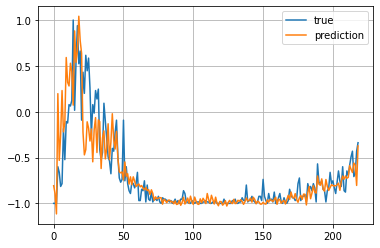

VALIDATION FR-O


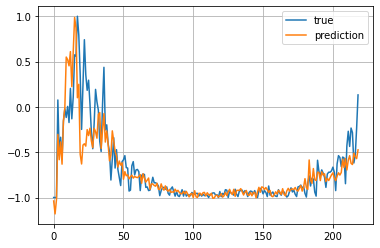

TEST FR-V


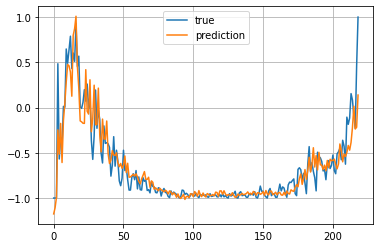

TEST FR-D


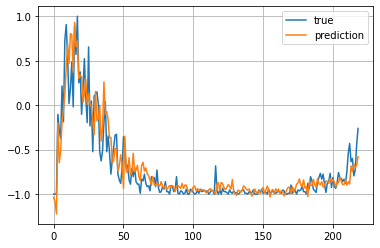

TEST FR-C


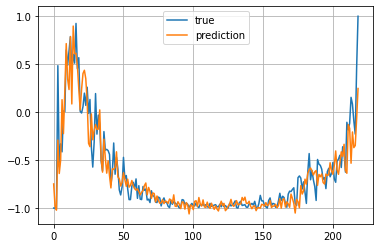

TEST FR-L


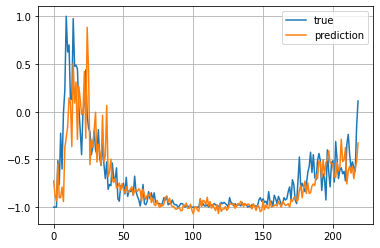

TEST BE


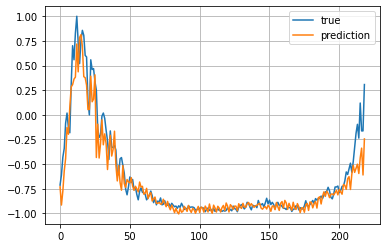

In [98]:
for loc in train_datapoints:
    print("TRAINING", loc)
    x, y = train_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in valid_datapoints:
    print("VALIDATION", loc)
    x, y = valid_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in test_datapoints:
    print("TEST", loc)
    x, y = test_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()

In [102]:
# compute MSE and MAE for 'dumb' estimation
def constant_estimator(x):
    return np.array([ [x[i][n_samples-1][0] for j in range(n_forecast)] for i in range(len(x))])


MSE = 0
MAE = 0
MSE_dumb = 0
MAE_dumb = 0
for loc in test_datapoints:
    x, y = test_datapoints[loc]
    yp = model.predict(x)
    y_dumb = constant_estimator(x)
    y_reshape = y.reshape(-1)
    yp_reshape = yp.reshape(-1)
    y_dumb_reshape = y_dumb.reshape(-1)
    MSE += mean_squared_error(y_reshape, yp_reshape)
    MAE += mean_absolute_error(y_reshape, yp_reshape)
    MSE_dumb += mean_squared_error(y_reshape, y_dumb_reshape)
    MAE_dumb += mean_absolute_error(y_reshape, y_dumb_reshape)
MSE /= len(test_datapoints)
MAE /= len(test_datapoints)
MSE_dumb /= len(test_datapoints)
MAE_dumb /= len(test_datapoints)
print('MSE = ', MSE, "\nMAE = ", MAE)
print('\nMSE_dumb = ', MSE_dumb, "\nMAE_dumb = ", MAE_dumb)


MSE =  0.03132158132743537 
MAE =  0.10641731867665485

MSE_dumb =  0.049343001360097574 
MAE_dumb =  0.12834480188184855
(73, 14, 16)
(73, 3, 1)


In [108]:
for loc in test_datapoints:
    x, y = test_datapoints[loc]
    print(y.shape)
for loc in train_datapoints:
    x, y = train_datapoints[loc]
    print(y.shape)
for loc in valid_datapoints:
    x, y = valid_datapoints[loc]
    print(y.shape)

(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)
(73, 3, 1)


# Let's use the validation set

In [115]:
import talos

def run_model(_, _2, _3, _4, p):
    model = Sequential()
    model.add(LSTM(p["n_lstm_node_first"], input_shape=(n_samples, n_features), 
              kernel_regularizer=p['reg'](p['regw'])))
    #if p["n_lstm_node_second"] != 0:
    #    model.add(LSTM(p["n_lstm_node_second"], return_sequences=True, kernel_regularizer=p['reg'](p['regw'])))
    #for _ in range(p["n_layers_after"]):
    #    model.add(TimeDistributed(Dense(p["n_node_hidden_layers"], kernel_regularizer=p['reg'](p['regw']), 
    #                    activation=p['activation'])))
    model.add(Dense(n_forecast, kernel_regularizer=p['reg'](p['regw'])))

    model.compile(loss=p["losses"], optimizer=p["optimizer"], metrics=['mae', 'mse'])
    history = model.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=p["epochs"], verbose=0, shuffle=False, 
              validation_data=validation_generator(),
              validation_steps=len(valid_datapoints))
    
    return history, model

p = {'activation':['relu', 'elu', 'sigmoid'],
     #'n_layers_after': [0, 1, 2],
     #'n_node_hidden_layers': [10, 30, 50],
     'n_lstm_node_first': [10, 20, 30],
     #'n_lstm_node_second': [0, 10, 20, 30],
     'reg': [lambda x: regularizers.l2(l=x), lambda x: regularizers.l1(l=x), lambda x: None],
     'regw': [1e-4, 5e-4, 1e-3],
     'optimizer': ['Adam', 'sgd'],
     'losses': ['mae', 'mse'],
     'epochs': [300, 500],
}
scan_object = talos.Scan(
    x=[],
    y=[],
    x_val=[],
    y_val=[],
    params=p,
    model=run_model,
    experiment_name='trends1', 
    fraction_limit=0.01
)

100%|██████████| 6/6 [03:29<00:00, 34.93s/it]


In [116]:
# compute MSE and MAE
analyze_object = talos.Analyze(scan_object)
print("MAE", analyze_object.low('mae'))
print("MSE", analyze_object.low('mse'))
print("VAL MAE", analyze_object.low('val_mae'))
print("VAL MSE", analyze_object.low('val_mse'))
analyze_object.table('val_mse', exclude=[], ascending=True)

MAE 0.06806714832782745
MSE 0.01227729395031929
VAL MAE 0.11170602589845657
VAL MSE 0.034881673753261566


,val_mse,mse,n_lstm_node_first,optimizer,mae,val_mae,losses,round_epochs,regw,start,duration,loss,activation,epochs,reg,val_loss,end
0,0.034882,0.027477,30,sgd,0.100661,0.112178,mae,300,0.0001,10/24/20-161443,28.173656,0.104070,elu,300,<function <lambda> at 0x7fa3d45228b0>,0.115587,10/24/20-161511
1,0.035362,0.027823,10,sgd,0.102354,0.114604,mae,500,0.0005,10/24/20-161511,36.746289,0.114357,elu,500,<function <lambda> at 0x7fa3d45228b0>,0.126607,10/24/20-161548
4,0.035603,0.027985,30,sgd,0.101562,0.114512,mae,300,0.0005,10/24/20-161701,28.518355,0.118280,sigmoid,300,<function <lambda> at 0x7fa3d45228b0>,0.131232,10/24/20-161729
5,0.037781,0.029516,20,sgd,0.109587,0.123280,mse,500,0.0001,10/24/20-161729,42.592010,0.046368,sigmoid,500,<function <lambda> at 0x7fa3edef0ee0>,0.054632,10/24/20-161812
2,0.040039,0.016419,20,Adam,0.075757,0.111706,mae,500,0.0005,10/24/20-161548,40.259732,0.088454,relu,500,<function <lambda> at 0x7fa3edef0ee0>,0.124357,10/24/20-161628
3,0.043190,0.012277,30,Adam,0.068067,0.126145,mae,300,0.0010,10/24/20-161629,31.795767,0.068067,elu,300,<function <lambda> at 0x7fa3ec1699d0>,0.126145,10/24/20-161700
